<a href="https://colab.research.google.com/github/cleitonmoya/MAE001_Trabalho1/blob/main/Trab1_MAE_vCleiton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Calibração do Modelo

Neste trabalho, utilizamos a série histórica de preços da ação preferencial do 
Bradesco (**BBDC4**) do período de 01.01.2019 a 31.03.2019 (3 meses). 

Os dados foram obtidos através da plataforma *Profit Trader Clear* (https://www.clear.com.br/site/plataformas/profit-trader-clear), o qual permite a exportação para um arquivo .csv.  Os arquivo CSV foi disponibilizado no GitHub e os então carregados com o auxílio da biblioteca Pandas.

In [249]:
import pandas as pd
import numpy as np

url = 'https://raw.githubusercontent.com/cleitonmoya/MAE001_Trabalho1/main/BBDC4.csv'
df = pd.read_csv(url, index_col=0, dayfirst=True, parse_dates=True)
df.sort_index(inplace=True)
df = df.loc['2019-01-01':'2019-03-31']
S = df.Fechamento.values

##a) Jumps
Cálculo do vetor de <i>jumps</i> ($J$), média ($m$) e desvio-padrão da amostra ($s$):

In [250]:
J = np.array([])
for n in range(1,len(S)):
    J = np.append(J,S[n]/S[n-1])
m = J.mean()
s = J.std(ddof=1)
print("Média:", m)
print("Desvio padrão:", s)

Média: 1.0012396197451972
Desvio padrão: 0.019439221045386368


##b) Gráfico de S e Crescimento Médio

28.83


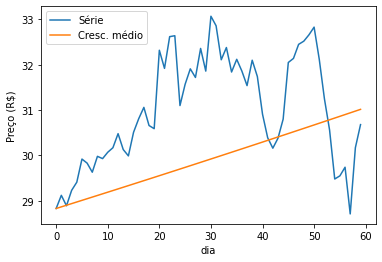

In [251]:

import matplotlib.pyplot as plt

t = np.array([S[0]])
for n in range(1,len(S)):
    t = np.append(t,t[n-1]*m)

plt.plot(S,label='Série')
plt.plot(t,label='Cresc. médio')
plt.xlabel("dia")
plt.ylabel("Preço (R$)")
plt.legend()

print(S[0])

## c) Gráfico das séries logarítmicas 

Neste item plotamos aplicamos o logaritmo (base 10) nas séries $S$ e $t$. 

Coeficiente angular: 0.0005380266096472564


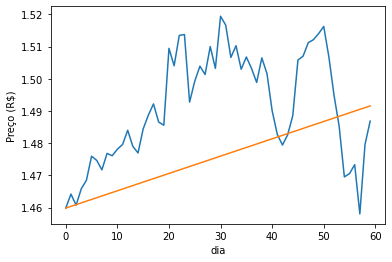

In [252]:
from numpy import log10
plt.plot(log10(S),label='Série')
plt.plot(log10(t),label='Cresc. médio')
plt.xlabel("dia")
plt.ylabel("Preço (R$)")
print("Coeficiente angular:", log10(m))

Observamos ambas as curvas possuem o mesmo formato do ítem anterior. \\
O coeficiente angular da reta corresponde ao logaritmo do retorno médio $log(m)$.

## d) Simulação de Caminhos

Para fazer a simulação dos caminhos, primeiramente precisamos calcular os valores de $u$ e $d$:

In [253]:
u = m + s
d = m - s
print("u:", u)
print("d:", d) 

u: 1.0206788407905836
d: 0.9818003986998107


Simulamos 5 caminhos partindo de $S_0$. Nas simulações, adotamos $p=1/2$ (modelo JR) e desprezamos a taxa de juros (assumimos $r=0$). 

Para fins de reprodutibilidade e possível conferência futura dos resultados, utilizamos uma semente (*seed*) para a geração dos números pseudo-aleatórios.

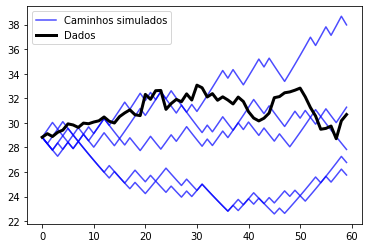

In [254]:
import random
random.seed(1000)
p = 1/2
for k in range(5):
    S1 = np.array([S[0]])
    sn = S[0]
    
    for n in range(1,len(S)):
        if (random.random() < p):
            sn = sn*u
        else:
            sn = sn*d
        S1 = np.append(S1,sn)

    if k==0:    
      plt.plot(S1, color='b', alpha=0.7, label="Caminhos simulados")
    else:
      plt.plot(S1, color='b', alpha=0.7)
plt.plot(S,color='k', linewidth=3, label="Dados")
plt.legend()

## e) Mudança da Escala de Tempo

Calculamos os novos parâmetros através do método JR.
Para determinarmos a taxa de juros, 



In [255]:
r_per = 0.00518295 # Fonte: BCB - Calculadora do Cidadão
n_dias = len(S)
r = (1+r_per)**(1/n_dias)-1
print("Taxa de juros:",r)

Taxa de juros: 8.616312424214456e-05


Verficando a condição de não-arbitragem: $d < (1+r) < u$ 

In [256]:
if (u>1+r) and (d<1+r):
  print("Condição satisfeita!")
else:
  print("Condição não satisfeita!")

Condição satisfeita!


Calculando os novos parâmetros para $\Delta T=1/10$ através do método JR:

In [257]:
dT = 1/10
s = np.sqrt((m**2+s**2)**dT-(m**2)**dT)
m = m**dT
u = m + s
d = m - s

print("u:", u)
print("d:", d)

u: 1.0062637435117279
d: 0.9939840422466516


Verficando a condição de não-arbitragem: $d < (1+r) < u$ 

In [258]:
if (u>1+r) and (d<1+r):
  print("Condição satisfeita!")
else:
  print("Condição não satisfeita!")

Condição satisfeita!


Plotando os caminhos:

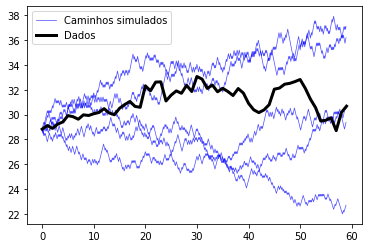

In [259]:
random.seed(1000)
p = 1/2
T = len(S)
for k in range(5):
    S1 = np.array([S[0]])
    sn = S[0]
    
    for n in np.arange(dT,T-1,dT):
        if (random.random() < p):
            sn = sn*u
        else:
            sn = sn*d
        S1 = np.append(S1,sn)

    if k==0:    
      plt.plot(np.arange(0,T-1,dT), S1, color='b', linewidth=0.7, alpha=0.7, label="Caminhos simulados")
    else:
      plt.plot(np.arange(0,T-1,dT), S1, color='b', linewidth=0.7, alpha=0.7)
plt.plot(range(0,len(S)),S,color='k', linewidth=3, label="Dados")
plt.legend()

# 2. Método de Monte Carlo

In [278]:
random.seed(1000)
S0 = 10
r = 0.01
N = 40
u = 1.13
d = 0.85
K = 45

def put(K,S):
  Sm = S.mean()
  if K > Sm:
    return K-Sm
  else:
    return 0

def call(K,S):
  Sm = S.mean()
  if Sm > K:
    return Sm-K
  else:
    return 0

Primeiramente, necessitamos verificar a presença de arbitragem:

In [276]:
if (u>1+r) and (d<1+r):
  print("Condição de não-arbitragem satisfeita!")
else:
  print("Condição não satisfeita!")

Condição de não-arbitragem satisfeita!


Probabilidade neutra a risco $p$:

In [315]:
p = (1+r-d)/(u-d)
print("p:",p)

p: 0.5714285714285717


Precisamos então gerar caminhos para o preço da ação.

In [262]:
def gera_caminho(N, S0, u, d, r):
  p = (1+r-d)/(u-d)
  s = np.zeros(N)
  s[0] = S0
  for i in range(1,N):
    if random.random() < p:
      s[i] = u*s[i-1]
    else:
      s[i] = d*s[i-1]
  return s

Simulação de caminhos do preço da ação:

In [263]:
s = np.zeros(N)
for n in range(200):
  S = gera_caminho(N, S0, u, d, r)
  s = np.vstack((s,S))

S_N médio: 15.615638400757751
S_N moda: 9.286402295576774


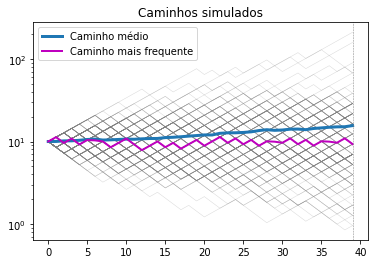

In [350]:
s = s[1:]
plt.title("Caminhos simulados")
plt.plot(s.T,linewidth=0.5, alpha=0.3, color='grey')
Sm = s.mean(0)
S_median = np.median(s,axis=0)
plt.plot(Sm,linewidth=3, label="Caminho médio")
plt.plot(S_median, linewidth=2, color='m', label="Caminho mais frequente")
plt.axvline(39, linewidth=0.5, linestyle='--', color='gray')
plt.yscale('log')
plt.legend()
print("S_N médio:",Sm[39])
print("S_N moda:",S_median[39])

Estimativa preliminar do preço do contrato com base no caminho médio do preço da ação:

In [282]:
print('Valor médio ao longo do caminho médio:', Sm.mean())
print('Vn call:', call(K,Sm.mean()))
print('Vn put:', put(K,Sm.mean()))

D = 1/(1+r)**N
print('D:',D)
print('V0 put:', D*put(K,Sm.mean()))

Valor médio ao longo do caminho médio: 12.176381453778555
Vn call: 0
Vn put: 32.82361854622145
D: 0.6716531388604381
V0 put: 22.046086425327324


Precificação pelo método de Monte Carlo:

In [267]:
# Precificação de contrato - Método de Monte Carlo
def monte_carlo(S0, MAX, N, u, d, r):
  D = 1/(1+r)**N
  soma = 0
  for m in range(MAX):
      Sm = gera_caminho(N, S0, u, d, r)
      soma =  soma + D*put(K,Sm)
  V0 = soma/MAX
  return V0

Execução do experimento:

In [292]:
MAX = np.array([200, 400, 800, 1600, 3200, 6400, 10000, 20000, 70000, 100000])

nit = 20 # número de iterações

V0 = np.zeros(len(MAX))
for k, max in enumerate(MAX):   
  # Executa o Monte-Carlo nit vezes 
  soma = 0
  for n in range(nit):
    soma = soma + monte_carlo(S0, max, N, u, d, r)
  V0[k] = soma/n
print("V0:", V0)

V0: [23.31251309 23.24080577 23.14147626 23.17661804 23.18783454 23.21884585
 23.19119763 23.19252931 23.19890765 23.20434296]


Cálculo do erro médio:

In [293]:
j = len(V0)
erro = abs((V0-V0[j-1])/V0[j-1])
print("Erro:", erro)

Erro: [0.00466163 0.00157138 0.00270926 0.00119482 0.00071144 0.00062501
 0.0005665  0.00050911 0.00023424 0.        ]


## b,c) Gráfico do Erro Relativo Médio e Estimativa da Ordem de Convergência 

slope: -0.461298    intercept: -1.403479
R-squared: 0.908485


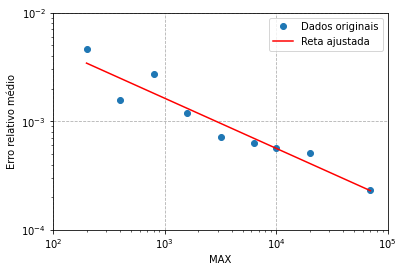

In [341]:
plt.plot(MAX,erro,'o',label='Dados originais')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MAX')
plt.ylabel('Erro relativo médio')
plt.xlim(10**2, 10**5)
plt.ylim(10**-4, 10**-2)
plt.grid(linestyle='--')

# Regressão linear
x = log10(MAX[:-1])
y = log10(erro[:-1])
x2=MAX[:-1]
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)
plt.plot(x2, 10**(intercept+ slope*x), label='Reta ajustada', color='r')
plt.legend()

Podemos verificar no gráfico que o coeficiente angular da reta é aproximadamente $-0.5$ e, portanto, a ordem de convergência do algoritmo dé próxima a $0.5$. Ou seja, o erro relativo se reduz na proporção da metade do aumento do número de caminhos simulados (iterações). 